In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tqdm as tqdm

2025-09-16 07:09:26.733055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758006566.903018      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758006566.952190      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tqdm import tqdm
import os
import numpy as np
import cv2

def load_data(image_path, mask_path, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Data"):
        new_image_path = os.path.join(image_path, image_file)
        new_mask_path = os.path.join(mask_path, mask_file)

        image = cv2.imread(new_image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Warning: Could not load image {image_file}")
            continue
        if mask is None:
            print(f"Warning: Could not load mask {mask_file}")
            continue

        image = cv2.resize(image, img_size) / 255.0 
        mask = cv2.resize(mask, img_size) / 255.0
        kernel = np.ones((3, 3), np.uint8)

        eroded_mask = cv2.erode(mask, kernel, iterations=1)
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        
        final_mask = dilated_mask # Or eroded_mask, or the original mask
        mask = np.expand_dims(final_mask, axis=-1)

        images.append(image)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)


In [3]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim, num_heads, ff_dim, num_layers):
        super().__init__()

        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = self.add_weight(name="pos_embedding", shape=(1, num_patches, embed_dim))

        self.transformer_layers = [
            keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
            for _ in range(num_layers)
        ]

        self.feed_forward = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        self.norm_layers = [layers.LayerNormalization() for _ in range(num_layers)]

    def call(self, x):
        x += self.pos_embedding

        for i in range(self.num_layers):
            attn_output = self.transformer_layers[i](x, x)
            x = self.norm_layers[i](x + attn_output)
            x = self.norm_layers[i](x + self.feed_forward(x))

        return x

In [4]:
def conv_block(inputs , num_filters) :
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

In [5]:
def build_transunet(img_size=256, patch_size=4, embed_dim=1024, num_heads=8, num_layers=6, ff_dim=2048, num_classes=1):

    inputs = layers.Input(shape=(img_size, img_size, 3))

    x00 = conv_block(inputs, 16)
    y00 = layers.MaxPooling2D((2, 2))(x00)
    x10 = conv_block(y00, 32)
    y10 = layers.MaxPooling2D((2, 2))(x10)
    x20 = conv_block(y10, 64)
    y20 = layers.MaxPooling2D((2, 2))(x20)

    num_patches = 64
    patch_dim = 1024

    x = layers.Reshape((num_patches, patch_dim))(y20)

    x = TransformerEncoder(num_patches, embed_dim, num_heads, ff_dim, num_layers)(x)

    x = layers.Reshape((32, 32, 64))(x)

    x21 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(x)
    x21 = layers.concatenate([x21, x20])
    x21 = conv_block(x21, 64) 

    x12 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(x21)
    x12 = layers.concatenate([x12, x10])
    x12 = conv_block(x12, 32)

    x03 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(x12)
    x03 = layers.concatenate([x03, x00])
    x03 = conv_block(x03, 16)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x03) 

    model = keras.Model(inputs, outputs)
    return model

model = build_transunet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

I0000 00:00:1758006579.197443      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 206,001,393 (785.83 MB)

 Trainable params: 206,000,497 (785.83 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
image_path = '/kaggle/input/new-crack/data/data-crack'
mask_path = '/kaggle/input/new-crack/data/new_mask_folder'

im, ma = load_data(image_path, mask_path)
print("DONE👍")

Loading Data: 100%|██████████| 1130/1130 [01:16<00:00, 14.81it/s]


DONE👍


In [7]:
# X_train, X_temp, Y_train, Y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train, X_temp, Y_train, Y_temp = train_test_split(im, ma, test_size=0.2, random_state=42)

X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 904, Validation: 113, Test: 113


In [8]:
# checkpoints = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
# ]

# history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=25, callbacks=callbacks, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=20,
    verbose=1
)

Epoch 1/20


I0000 00:00:1758006689.051868      95 service.cc:148] XLA service 0x7a31340158e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758006689.052617      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758006691.817728      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758006706.527943      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 96s 889ms/step - accuracy: 0.7330 - loss: 0.6061 - val_accuracy: 0.0965 - val_loss: 2.0482
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9762 - loss: 0.2906 - val_accuracy: 0.9695 - val_loss: 0.3181
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9770 - loss: 0.2266 - val_accuracy: 0.9704 - val_loss: 0.2503
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9793 - loss: 0.1726 - val_accuracy: 0.9704 - val_loss: 0.2009
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9808 - loss: 0.1399 - val_accuracy: 0.9720 - val_loss: 0.1589
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9836 - loss: 0.1098 - val_accuracy: 0.9763 - val_loss: 0.1169
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9833 - loss: 0.0942 - val_accuracy: 0.9812 - val_loss: 0.1034
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9838 - loss: 0.0826 - val_accuracy: 0.984

In [19]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.35).astype(np.uint8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [21]:
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

ious = [iou_score(Y_test[i], Y_pred[i]) for i in range(len(Y_test))]
mean_iou = np.mean(ious)

print(f"Mean IoU Score: {mean_iou:.4f}")


Mean IoU Score: 0.6181


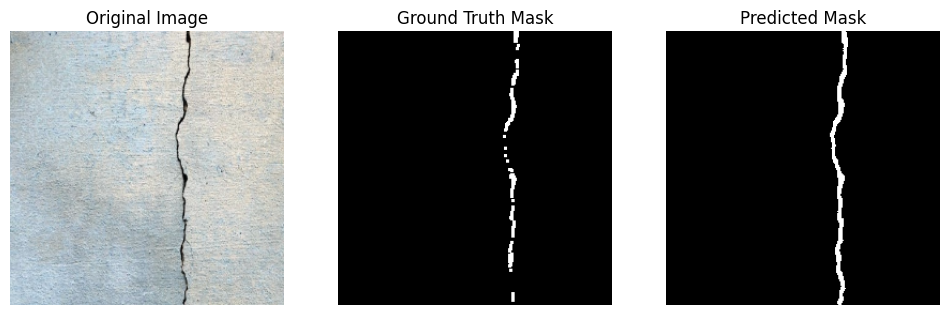

Sample IoU Score: 0.5863


In [50]:
import random

random_index = random.randint(0, len(X_test) - 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[random_index])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(Y_test[random_index], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(Y_pred[random_index], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()

iou_score_sample = iou_score(Y_test[random_index], Y_pred[random_index])
print(f"Sample IoU Score: {iou_score_sample:.4f}")